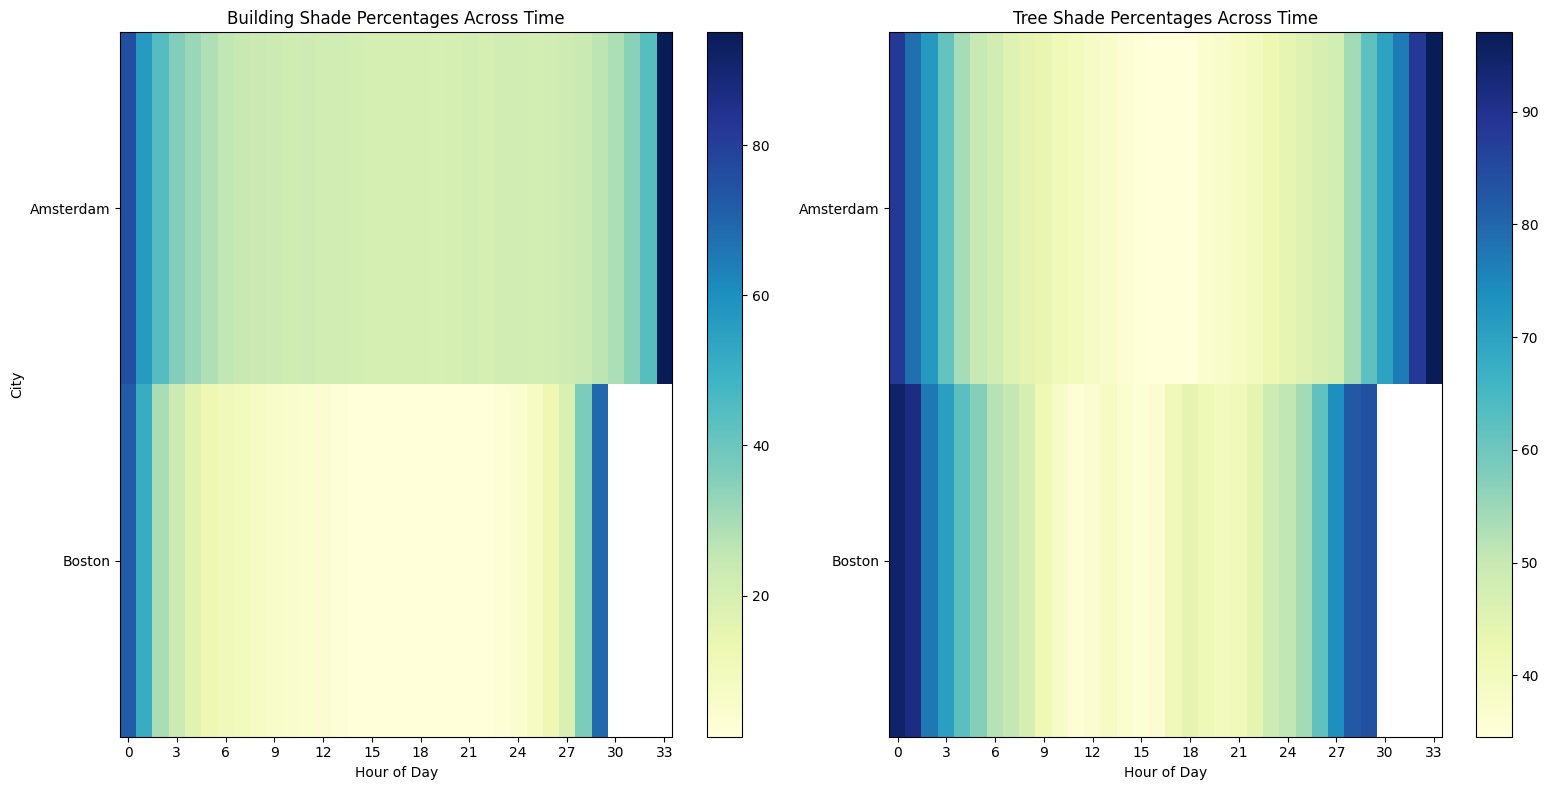

In [5]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Updated city details with OSMID and target date
city_details = {
    # "Stockholm": {"osmid": "398021", "date": "2024-06-20"},
    "Amsterdam": {"osmid": "271110", "date": "2024-06-20"},
    "Boston": {"osmid": "2315704", "date": "2024-06-20"},
    "Cambridge": {"osmid": "1933745", "date": "2024-06-20"},
    "Tunis": {"osmid": "8896976", "date": "2024-06-20"},
    "Hong Kong": {"osmid": "913110", "date": "2025-06-20"},
    "Singapore": {"osmid": "536780", "date": "2024-03-20"},
    "Belem": {"osmid": "185567", "date": "2025-03-20"},
    "Rio": {"osmid": "2697338", "date": "2025-12-21"},
    "Cape Town": {"osmid": "79604", "date": "2025-12-21"},
    "Sydney": {"osmid": "1251066", "date": "2025-12-21"},
}

# Enable test run
test_run = True
if test_run:
    city_details = {k: city_details[k] for k in list(city_details.keys())[:2]}

# Base path to the folders containing city files
base_path = "../results/output"

# Placeholder for processed data
building_shade = []
tree_shade = []

# Process data for each city
for city, details in city_details.items():
    osmid = details["osmid"]
    target_date = details["date"]

    # Construct the file path
    file_path = f"{base_path}/{osmid}/{osmid}_sidewalks_with_stats_multiple_dates.gpkg"

    try:
        # Load city data
        city_data = gpd.read_file(file_path)

        # Extract columns matching the target date
        date_str = target_date.replace("-", "")
        column_pattern = rf"{date_str}_(building|tree)_shade_percent_at_\d+"
        matched_columns = [col for col in city_data.columns if re.match(column_pattern, col)]
        
        if not matched_columns:
            print(f"No data columns for {city} on {target_date}. Skipping...")
            continue

        # Separate columns for building and tree
        building_columns = [col for col in matched_columns if "_building_" in col]
        tree_columns = [col for col in matched_columns if "_tree_" in col]

        # Extract available times
        time_pattern = rf"{date_str}_\w+_shade_percent_at_(\d+)"
        building_times = sorted([int(re.search(time_pattern, col).group(1)) for col in building_columns])
        tree_times = sorted([int(re.search(time_pattern, col).group(1)) for col in tree_columns])

        # Sort columns by time
        sorted_building_columns = [col for _, col in sorted(zip(building_times, building_columns))]
        sorted_tree_columns = [col for _, col in sorted(zip(tree_times, tree_columns))]

        # Compute mean values for each timestep
        building_mean_values = city_data[sorted_building_columns].mean()
        tree_mean_values = city_data[sorted_tree_columns].mean()

        # Store results
        building_shade.append(building_mean_values.values)
        tree_shade.append(tree_mean_values.values)

    except FileNotFoundError:
        print(f"File not found for {city} at {file_path}. Skipping...")
        continue

# Convert to DataFrame for labeling
hours_building = range(len(building_shade[0])) if building_shade else range(0)
hours_tree = range(len(tree_shade[0])) if tree_shade else range(0)
city_names = list(city_details.keys())

building_shade_df = pd.DataFrame(building_shade, index=city_names, columns=hours_building)
tree_shade_df = pd.DataFrame(tree_shade, index=city_names, columns=hours_tree)

# Plotting heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Building shade heatmap
im1 = axes[0].imshow(building_shade_df, aspect='auto', cmap='YlGnBu', interpolation='nearest')
axes[0].set_title("Building Shade Percentages Across Time")
axes[0].set_yticks(range(len(city_details)))
axes[0].set_yticklabels(building_shade_df.index)
axes[0].set_xticks(range(0, len(building_shade[0]), 3))
axes[0].set_xticklabels(hours_building[::3])
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("City")
fig.colorbar(im1, ax=axes[0], orientation='vertical')

# Tree shade heatmap
im2 = axes[1].imshow(tree_shade_df, aspect='auto', cmap='YlGnBu', interpolation='nearest')
axes[1].set_title("Tree Shade Percentages Across Time")
axes[1].set_yticks(range(len(city_details)))
axes[1].set_yticklabels(tree_shade_df.index)
axes[1].set_xticks(range(0, len(tree_shade[0]), 3))
axes[1].set_xticklabels(hours_tree[::3])
axes[1].set_xlabel("Hour of Day")
fig.colorbar(im2, ax=axes[1], orientation='vertical')

plt.tight_layout()
plt.show()

In [12]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Updated city details with OSMID and target date
city_details = {
    # "Stockholm": {"osmid": "398021", "date": "2024-06-20"},
    "Amsterdam": {"osmid": "271110", "date": "2024-06-20"},
    "Boston": {"osmid": "2315704", "date": "2024-06-20"},
    "Cambridge": {"osmid": "1933745", "date": "2024-06-20"},
    "Tunis": {"osmid": "8896976", "date": "2024-06-20"},
    # "Hong Kong": {"osmid": "913110", "date": "2025-06-20"},
    "Singapore": {"osmid": "536780", "date": "2024-03-20"},
    "Belem": {"osmid": "185567", "date": "2025-03-20"},
    # "Rio": {"osmid": "2697338", "date": "2025-12-21"},
    # "Cape Town": {"osmid": "79604", "date": "2025-12-21"},
    "Sydney": {"osmid": "1251066", "date": "2025-12-21"},
}

# Enable test run and visualization toggle
test_run = False
visualize = False
if test_run:
    city_details = {k: city_details[k] for k in list(city_details.keys())[:2]}

# Base path to the folders containing city files
base_path = "../results/output"

# Placeholder for processed data
building_shade = []
tree_shade = []
all_hours = range(48)  # 48 slots for 30-minute intervals (0:00 to 24:00)

# Process data for each city
for city, details in city_details.items():
    print(f"Processing city: {city} ({details['osmid']})...")
    osmid = details["osmid"]
    target_date = details["date"]

    # Construct the file path
    file_path = f"{base_path}/{osmid}/{osmid}_sidewalks_with_stats_multiple_dates.gpkg"

    try:
        # Load city data
        city_data = gpd.read_file(file_path, engine='pyogrio')
        print(f"Loaded data for {city}. Columns: {list(city_data.columns)[:5]}...")

        # Extract columns matching the target date
        date_str = target_date.replace("-", "")
        column_pattern = rf"{date_str}_(building|tree)_shade_percent_at_(\d+)"
        matched_columns = [col for col in city_data.columns if re.match(column_pattern, col)]
        
        if not matched_columns:
            print(f"No data columns for {city} on {target_date}. Skipping...")
            continue

        # Separate columns for building and tree
        building_columns = [col for col in matched_columns if "_building_" in col]
        tree_columns = [col for col in matched_columns if "_tree_" in col]

        # Extract available times
        time_pattern = rf"{date_str}_(building|tree)_shade_percent_at_(\d+)"
        building_times = [int(re.search(time_pattern, col).group(2)) for col in building_columns]
        tree_times = [int(re.search(time_pattern, col).group(2)) for col in tree_columns]

        # Normalize times to 30-minute intervals and sort
        sorted_building_columns = [col for _, col in sorted(zip(building_times, building_columns))]
        sorted_tree_columns = [col for _, col in sorted(zip(tree_times, tree_columns))]

        # Prepare arrays for full 24-hour coverage (48 slots for 30-minute intervals)
        building_full = np.full(len(all_hours), 100.0)  # Default to 100%
        tree_full = np.full(len(all_hours), 100.0)

        # Normalize times to 30-minute intervals
        def normalize_time_to_index(time):
            hour = time // 100
            minute = time % 100
            return hour * 2 + minute // 30

        building_indices = [normalize_time_to_index(t) for t in building_times]
        tree_indices = [normalize_time_to_index(t) for t in tree_times]

        # Prepare arrays for full 24-hour coverage (48 slots for 30-minute intervals)
        building_full = np.full(len(all_hours), 100.0)  # Default to 100%
        tree_full = np.full(len(all_hours), 100.0)

        # Fill with actual data
        for idx, col in zip(building_indices, sorted_building_columns):
            if idx < len(all_hours):  # Ensure index is within range
                building_full[idx] = city_data[col].mean()

        for idx, col in zip(tree_indices, sorted_tree_columns):
            if idx < len(all_hours):  # Ensure index is within range
                tree_full[idx] = city_data[col].mean()

        # Store results
        building_shade.append(building_full)
        tree_shade.append(tree_full)

        print(f"Completed processing for {city}.")
    except FileNotFoundError:
        print(f"File not found for {city} at {file_path}. Skipping...")
        continue

# Convert to DataFrame for labeling
city_names = list(city_details.keys())
building_shade_df = pd.DataFrame(building_shade, index=city_names, columns=[f"{h//2:02}:{h%2*30:02}" for h in all_hours])
tree_shade_df = pd.DataFrame(tree_shade, index=city_names, columns=[f"{h//2:02}:{h%2*30:02}" for h in all_hours])

# Print DataFrame preview
print("\nBuilding Shade DataFrame:")
print(building_shade_df.head())

print("\nTree Shade DataFrame:")
print(tree_shade_df.head())

# Plotting heatmaps if visualization is enabled
if visualize:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Building shade heatmap
    im1 = axes[0].imshow(building_shade_df, aspect='auto', cmap='YlGnBu', interpolation='nearest')
    axes[0].set_title("Building Shade Percentages Across Time")
    axes[0].set_yticks(range(len(city_details)))
    axes[0].set_yticklabels(building_shade_df.index)
    axes[0].set_xticks(range(0, len(all_hours), 6))
    axes[0].set_xticklabels(building_shade_df.columns[::6])
    axes[0].set_xlabel("Time of Day")
    axes[0].set_ylabel("City")
    fig.colorbar(im1, ax=axes[0], orientation='vertical')

    # Tree shade heatmap
    im2 = axes[1].imshow(tree_shade_df, aspect='auto', cmap='YlGnBu', interpolation='nearest')
    axes[1].set_title("Tree Shade Percentages Across Time")
    axes[1].set_yticks(range(len(city_details)))
    axes[1].set_yticklabels(tree_shade_df.index)
    axes[1].set_xticks(range(0, len(all_hours), 6))
    axes[1].set_xticklabels(tree_shade_df.columns[::6])
    axes[1].set_xlabel("Time of Day")
    fig.colorbar(im2, ax=axes[1], orientation='vertical')

    plt.tight_layout()
    plt.show()

Processing city: Amsterdam (271110)...
Loaded data for Amsterdam. Columns: ['allowed_turns', 'direction', 'index', 'layer', 'muv']...
Completed processing for Amsterdam.
Processing city: Boston (2315704)...
Loaded data for Boston. Columns: ['allowed_turns', 'direction', 'index', 'layer', 'muv']...
Completed processing for Boston.
Processing city: Cambridge (1933745)...
Loaded data for Cambridge. Columns: ['allowed_turns', 'direction', 'index', 'layer', 'muv']...
Completed processing for Cambridge.
Processing city: Tunis (8896976)...
Loaded data for Tunis. Columns: ['allowed_turns', 'direction', 'index', 'layer', 'muv']...
Completed processing for Tunis.
Processing city: Singapore (536780)...
Loaded data for Singapore. Columns: ['allowed_turns', 'direction', 'index', 'layer', 'muv']...
Completed processing for Singapore.
Processing city: Belem (185567)...
Loaded data for Belem. Columns: ['allowed_turns', 'direction', 'index', 'layer', 'muv']...
Completed processing for Belem.
Processing

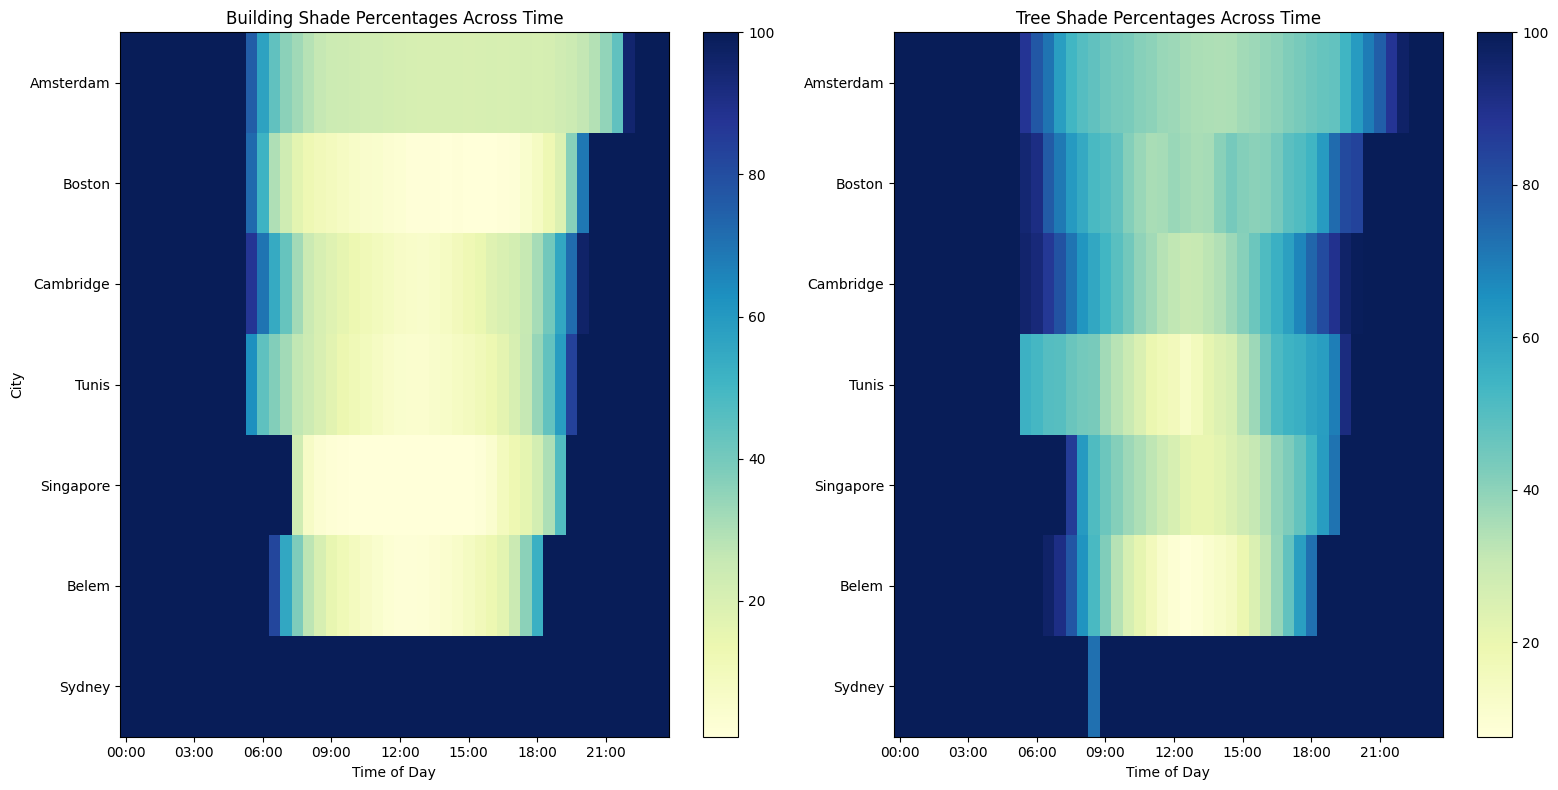

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Building shade heatmap
im1 = axes[0].imshow(building_shade_df, aspect='auto', cmap='YlGnBu', interpolation='nearest')
axes[0].set_title("Building Shade Percentages Across Time")
axes[0].set_yticks(range(len(city_details)))
axes[0].set_yticklabels(building_shade_df.index)
axes[0].set_xticks(range(0, len(all_hours), 6))
axes[0].set_xticklabels(building_shade_df.columns[::6])
axes[0].set_xlabel("Time of Day")
axes[0].set_ylabel("City")
fig.colorbar(im1, ax=axes[0], orientation='vertical')

# Tree shade heatmap
im2 = axes[1].imshow(tree_shade_df, aspect='auto', cmap='YlGnBu', interpolation='nearest')
axes[1].set_title("Tree Shade Percentages Across Time")
axes[1].set_yticks(range(len(city_details)))
axes[1].set_yticklabels(tree_shade_df.index)
axes[1].set_xticks(range(0, len(all_hours), 6))
axes[1].set_xticklabels(tree_shade_df.columns[::6])
axes[1].set_xlabel("Time of Day")
fig.colorbar(im2, ax=axes[1], orientation='vertical')

plt.tight_layout()
plt.show()

/tmp/ipykernel_1886691/1070947699.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10")  # Choose a colormap


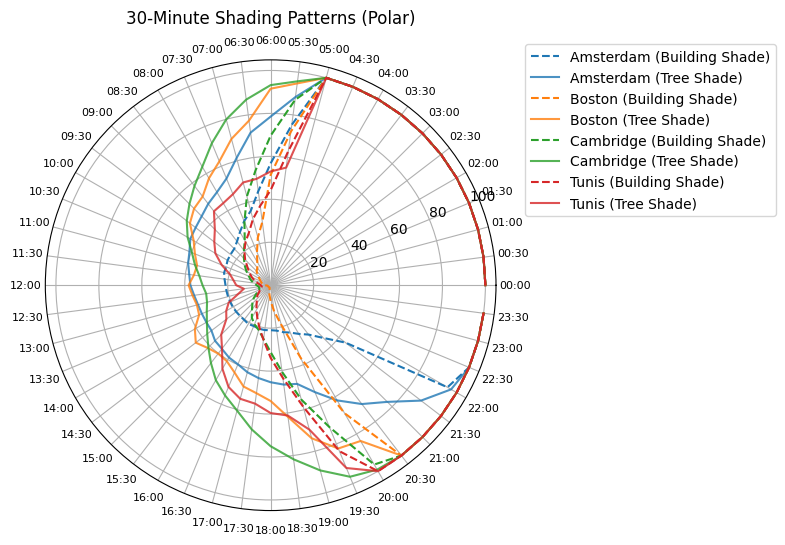

In [15]:
from matplotlib.projections.polar import PolarAxes
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Define hours in 30-minute intervals for the polar plot
theta = np.linspace(0, 2 * np.pi, len(building_shade_df.columns), endpoint=False)

# Define a colormap and assign consistent colors to cities
cmap = get_cmap("tab10")  # Choose a colormap
city_colors = {city: cmap(i) for i, city in enumerate(building_shade_df.index)}

# Create a polar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

# Iterate over the first 4 cities (or fewer, depending on test_run)
for i, city in enumerate(building_shade_df.index[:4]):
    # Use consistent color for the city
    color = city_colors[city]
    
    # Plot building shade
    ax.plot(
        theta, 
        building_shade_df.loc[city], 
        label=f"{city} (Building Shade)", 
        linestyle="--", 
        color=color
    )
    # Plot tree shade
    ax.plot(
        theta, 
        tree_shade_df.loc[city], 
        label=f"{city} (Tree Shade)", 
        alpha=0.8, 
        color=color
    )

# Set theta labels to display time of day (convert column names to readable format)
time_labels = building_shade_df.columns.tolist()
ax.set_xticks(theta)
ax.set_xticklabels(time_labels, fontsize=8)

# Add title, legend, and adjust layout
ax.set_title("30-Minute Shading Patterns (Polar)", va='bottom', fontsize=12)
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.05))
plt.tight_layout()
plt.show()

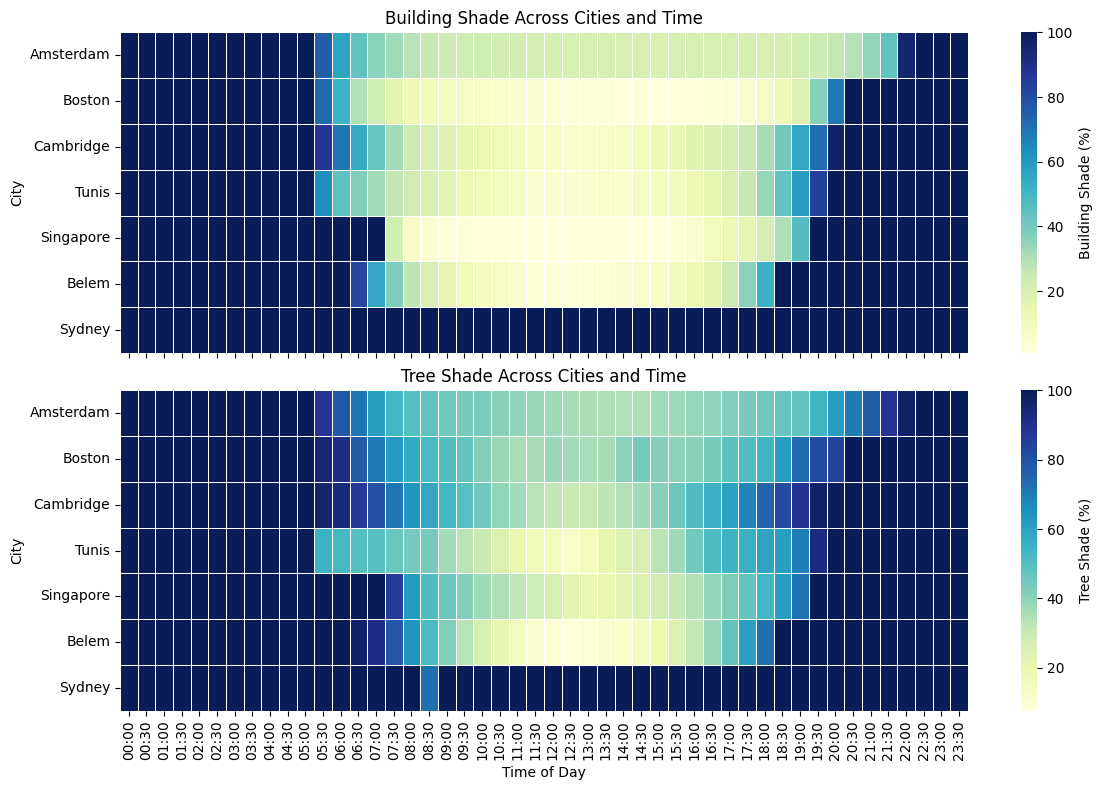

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two heatmaps
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Building shade heatmap
sns.heatmap(
    building_shade_df, 
    ax=axes[0], 
    cmap="YlGnBu", 
    cbar_kws={'label': 'Building Shade (%)'},
    linewidths=0.5
)
axes[0].set_title("Building Shade Across Cities and Time")
axes[0].set_ylabel("City")

# Tree shade heatmap
sns.heatmap(
    tree_shade_df, 
    ax=axes[1], 
    cmap="YlGnBu", 
    cbar_kws={'label': 'Tree Shade (%)'},
    linewidths=0.5
)
axes[1].set_title("Tree Shade Across Cities and Time")
axes[1].set_xlabel("Time of Day")
axes[1].set_ylabel("City")

plt.tight_layout()
plt.show()

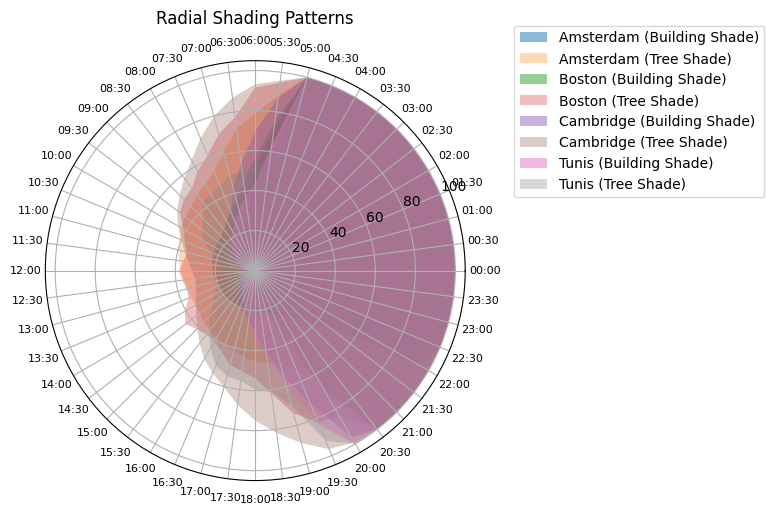

In [18]:
from matplotlib.projections.polar import PolarAxes

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

# Define theta for 30-minute intervals
theta = np.linspace(0, 2 * np.pi, len(building_shade_df.columns), endpoint=False)

for i, city in enumerate(building_shade_df.index[:4]):  # First 4 cities for example
    # Radial area for building shade
    ax.fill(theta, building_shade_df.loc[city].values, alpha=0.5, label=f"{city} (Building Shade)")
    # Radial area for tree shade
    ax.fill(theta, tree_shade_df.loc[city].values, alpha=0.3, label=f"{city} (Tree Shade)")

# Customize labels and layout
ax.set_xticks(theta)
ax.set_xticklabels(building_shade_df.columns, fontsize=8)
ax.set_title("Radial Shading Patterns", va='bottom', fontsize=12)
ax.legend(loc="upper left", bbox_to_anchor=(1.1, 1.1))

plt.tight_layout()
plt.show()

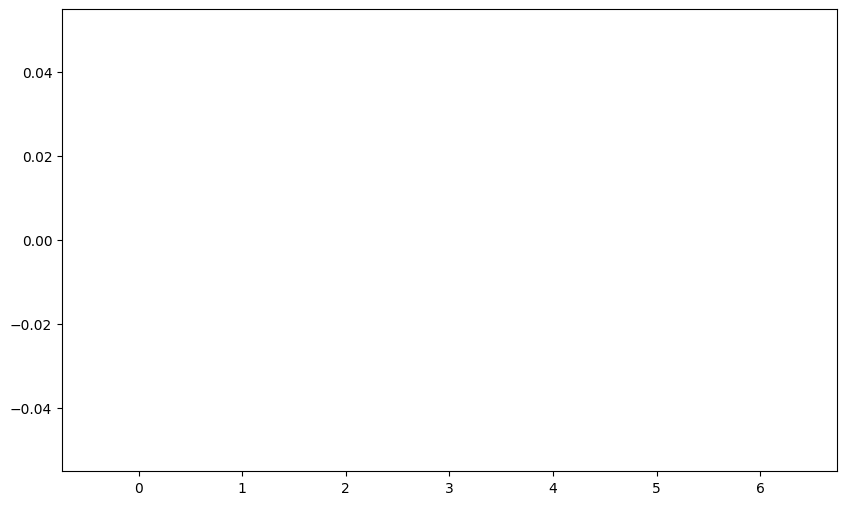

In [19]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Setup figure
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(building_shade_df.index))
bars = ax.bar(x, [0] * len(x), color="skyblue")

# Update function for animation
def update(frame):
    for bar, height in zip(bars, building_shade_df.iloc[:, frame]):
        bar.set_height(height)
    ax.set_title(f"Shade Race at {building_shade_df.columns[frame]}")

# Run animation
ani = FuncAnimation(fig, update, frames=len(building_shade_df.columns), interval=200, repeat=True)
plt.show()

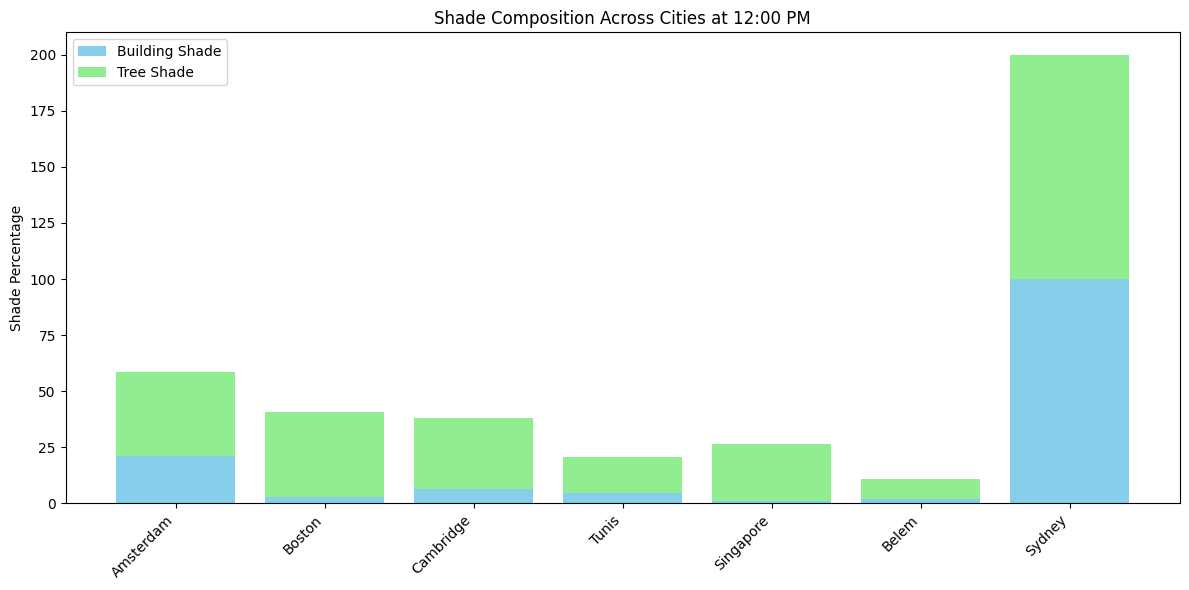

In [20]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 6))

# Example: Plot for one time interval (e.g., 12:00 PM)
time_idx = building_shade_df.columns.get_loc("12:00")
x = np.arange(len(building_shade_df.index))  # Cities
building_values = building_shade_df.iloc[:, time_idx]
tree_values = tree_shade_df.iloc[:, time_idx]

# Stacked bar chart
ax.bar(x, building_values, label="Building Shade", color="skyblue")
ax.bar(x, tree_values, bottom=building_values, label="Tree Shade", color="lightgreen")

# Add labels and legend
ax.set_xticks(x)
ax.set_xticklabels(building_shade_df.index, rotation=45, ha='right')
ax.set_ylabel("Shade Percentage")
ax.set_title("Shade Composition Across Cities at 12:00 PM")
ax.legend()

plt.tight_layout()
plt.show()